# **Homework 10 - Adversarial Attack**

Slides: https://reurl.cc/7DDxnD

Contact: ntu-ml-2022spring-ta@googlegroups.com


## Enviroment & Download

We make use of [pytorchcv](https://pypi.org/project/pytorchcv/) to obtain CIFAR-10 pretrained model, so we need to set up the enviroment first. We also need to download the data (200 images) which we want to attack.

In [1]:
!nvidia-smi

Mon May  9 10:48:10 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import os

# your workspace in your drive
workspace = 'ML2022-hw10'


try:
  os.chdir(os.path.join('/content/gdrive/MyDrive/', workspace))
except:
  os.mkdir(os.path.join('/content/gdrive/MyDrive/', workspace))
  os.chdir(os.path.join('/content/gdrive/MyDrive/', workspace))

In [4]:
# set up environment
!pip install pytorchcv
!pip install imgaug

# # download
# !wget https://github.com/DanielLin94144/ML-attack-dataset/files/8167812/data.zip

# # unzip
# !unzip ./data.zip
# !rm ./data.zip

     |████████████████████████████████| 532 kB 28.8 MB/s 


In [5]:
import torch
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 8

In [6]:
# the mean and std are the calculated statistics from cifar_10 dataset
cifar_10_mean = (0.491, 0.482, 0.447) # mean for the three channels of cifar_10 images
cifar_10_std = (0.202, 0.199, 0.201) # std for the three channels of cifar_10 images

# convert mean and std to 3-dimensional tensors for future operations
mean = torch.tensor(cifar_10_mean).to(device).view(3, 1, 1)
std = torch.tensor(cifar_10_std).to(device).view(3, 1, 1)

epsilon = 8/255/std

In [7]:
# perform fgsm attack
def fgsm(model, x, y, loss_fn, epsilon=epsilon):
    x_adv = x.detach().clone() # initialize x_adv as original benign image x
    x_adv.requires_grad = True # need to obtain gradient of x_adv, thus set required grad
    loss = loss_fn(model(x_adv), y) # calculate loss
    loss.backward() # calculate gradient
    # fgsm: use gradient ascent on x_adv to maximize loss
    grad = x_adv.grad.detach()
    x_adv = x_adv + epsilon * grad.sign()
    return x_adv

# alpha and num_iter can be decided by yourself
alpha = 0.8/255/std
def ifgsm(model, x, y, loss_fn, epsilon=epsilon, alpha=alpha, num_iter=20):
    x_adv = x
    # write a loop of num_iter to represent the iterative times
    for i in range(num_iter):
        # x_adv = fgsm(model, x_adv, y, loss_fn, alpha) # call fgsm with (epsilon = alpha) to obtain new x_adv
        x_adv = x_adv.detach().clone()
        x_adv.requires_grad = True # need to obtain gradient of x_adv, thus set required grad
        loss = loss_fn(model(x_adv), y) # calculate loss
        loss.backward() # calculate gradient
        # fgsm: use gradient ascent on x_adv to maximize loss
        grad = x_adv.grad.detach()
        x_adv = x_adv + alpha * grad.sign()

        x_adv = torch.max(torch.min(x_adv, x+epsilon), x-epsilon) # clip new x_adv back to [x-epsilon, x+epsilon]
    return x_adv

def mifgsm(model, x, y, loss_fn, epsilon=epsilon, alpha=alpha, num_iter=20, decay=1.0):
    x_adv = x
    # initialze momentum tensor
    momentum = torch.zeros_like(x).detach().to(device)
    # write a loop of num_iter to represent the iterative times
    for i in range(num_iter):
        x_adv = x_adv.detach().clone()
        x_adv.requires_grad = True # need to obtain gradient of x_adv, thus set required grad
        loss = loss_fn(model(x_adv), y) # calculate loss
        loss.backward() # calculate gradient
        # TODO: Momentum calculation
        # grad = .....
        x_adv = x_adv + alpha * grad.sign()
        x_adv = torch.max(torch.min(x_adv, x+epsilon), x-epsilon) # clip new x_adv back to [x-epsilon, x+epsilon]
    return x_adv

## Global Settings 
#### **[NOTE]**: Don't change the settings here, or your generated image might not meet the constraint.
* $\epsilon$ is fixed to be 8. But on **Data section**, we will first apply transforms on raw pixel value (0-255 scale) **by ToTensor (to 0-1 scale)** and then **Normalize (subtract mean divide std)**. $\epsilon$ should be set to $\frac{8}{255 * std}$ during attack.

* Explaination (optional)
    * Denote the first pixel of original image as $p$, and the first pixel of adversarial image as $a$.
    * The $\epsilon$ constraints tell us $\left| p-a \right| <= 8$.
    * ToTensor() can be seen as a function where $T(x) = x/255$.
    * Normalize() can be seen as a function where $N(x) = (x-mean)/std$ where $mean$ and $std$ are constants.
    * After applying ToTensor() and Normalize() on $p$ and $a$, the constraint becomes $\left| N(T(p))-N(T(a)) \right| = \left| \frac{\frac{p}{255}-mean}{std}-\frac{\frac{a}{255}-mean}{std} \right| = \frac{1}{255 * std} \left| p-a \right| <= \frac{8}{255 * std}.$
    * So, we should set $\epsilon$ to be $\frac{8}{255 * std}$ after ToTensor() and Normalize().

In [8]:
# the mean and std are the calculated statistics from cifar_10 dataset
cifar_10_mean = (0.491, 0.482, 0.447) # mean for the three channels of cifar_10 images
cifar_10_std = (0.202, 0.199, 0.201) # std for the three channels of cifar_10 images

# convert mean and std to 3-dimensional tensors for future operations
mean = torch.tensor(cifar_10_mean).to(device).view(3, 1, 1)
std = torch.tensor(cifar_10_std).to(device).view(3, 1, 1)

epsilon = 8/255/std

In [9]:
root = './data' # directory for storing benign images
# benign images: images which do not contain adversarial perturbations
# adversarial images: images which include adversarial perturbations

## Data

Construct dataset and dataloader from root directory. Note that we store the filename of each image for future usage.

In [79]:
import os
import glob
import shutil
import numpy as np
from PIL import Image
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader

transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize(cifar_10_mean, cifar_10_std)
])

class AdvDataset(Dataset):
    def __init__(self, data_dir, transform):
        self.images = []
        self.labels = []
        self.names = []
        '''
        data_dir
        ├── class_dir
        │   ├── class1.png
        │   ├── ...
        │   ├── class20.png
        '''
        for i, class_dir in enumerate(sorted(glob.glob(f'{data_dir}/*'))):
            images = sorted(glob.glob(f'{class_dir}/*'))
            self.images += images
            self.labels += ([i] * len(images))
            self.names += [os.path.relpath(imgs, data_dir) for imgs in images]
        self.transform = transform
    def __getitem__(self, idx):
        image = self.transform(Image.open(self.images[idx]))
        label = self.labels[idx]
        return image, label
    def __getname__(self):
        return self.names
    def __len__(self):
        return len(self.images)

adv_set = AdvDataset(root, transform=transform)
adv_names = adv_set.__getname__()
adv_loader = DataLoader(adv_set, batch_size=batch_size, shuffle=False)

print(f'number of images = {adv_set.__len__()}')

number of images = 200


In [12]:
# create directory which stores adversarial examples
def create_dir(data_dir, adv_dir, adv_examples, adv_names):
    if os.path.exists(adv_dir) is not True:
        _ = shutil.copytree(data_dir, adv_dir)
    for example, name in zip(adv_examples, adv_names):
        im = Image.fromarray(example.astype(np.uint8)) # image pixel value should be unsigned int
        im.save(os.path.join(adv_dir, name))

## Model / Loss Function

Model list is available [here](https://github.com/osmr/imgclsmob/blob/master/pytorch/pytorchcv/model_provider.py). Please select models which has _cifar10 suffix. Some of the models cannot be accessed/loaded. You can safely skip them since TA's model will not use those kinds of models.

In [13]:
from pytorchcv.model_provider import get_model as ptcv_get_model

In [14]:
model = ptcv_get_model('resnet110_cifar10', pretrained=True).to(device)

In [15]:
!pip install torchattacks

     |████████████████████████████████| 105 kB 42.0 MB/s 


In [80]:
images = []
labels = []
for i, class_dir in enumerate(sorted(glob.glob(root + '/*'))):
    image = sorted(glob.glob(f'{class_dir}/*'))
    for img in image:
        tmp = torch.Tensor(transform(Image.open(img)))
        images.append(tmp)
    labels += [int(i)] * len(image)
images = torch.stack(images)
labels = torch.LongTensor(labels)

In [127]:
class ensembleNet(nn.Module):
    def __init__(self, model_names):
        super().__init__()
        self.models = nn.ModuleList([ptcv_get_model(name, pretrained=True) for name in model_names])
        
    def forward(self, x):
        logits = []
        cnt = 0
        for i, m in enumerate(self.models):
        # TODO: sum up logits from multiple models  
            logits.append(m.logits)
            cnt += 1
        return logits/cnt
        # return ensemble_logits

In [128]:
model_names = [
    'nin_cifar10',
    'resnet20_cifar10',
    'preresnet20_cifar10',
    'resnext29_16x64d_cifar10',
    'resnext29_32x4d_cifar10',
    'resnet110_cifar10',
    'diapreresnet110_cifar10'
]
ensemble_model = ensembleNet(model_names).to(device)
ensemble_model.eval()

ensembleNet(
  (models): ModuleList(
    (0): CIFARNIN(
      (features): Sequential(
        (stage1): Sequential(
          (unit1): NINConv(
            (conv): Conv2d(3, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
            (activ): ReLU(inplace=True)
          )
          (unit2): NINConv(
            (conv): Conv2d(192, 160, kernel_size=(1, 1), stride=(1, 1))
            (activ): ReLU(inplace=True)
          )
          (unit3): NINConv(
            (conv): Conv2d(160, 96, kernel_size=(1, 1), stride=(1, 1))
            (activ): ReLU(inplace=True)
          )
        )
        (stage2): Sequential(
          (pool2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          (dropout2): Dropout(p=0.5, inplace=False)
          (unit1): NINConv(
            (conv): Conv2d(96, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
            (activ): ReLU(inplace=True)
          )
          (unit2): NINConv(
            (conv): Conv2d(192, 19

In [ ]:
import torchattacks
attack = torchattacks.EOTPGD(model, eps=7/255, alpha=1/255, steps=250, eot_iter=10)
adv_images = attack(images, labels)

In [ ]:
def pro_process(temp_img, input_size):
    # print(temp_img.shape)
    img = np.asarray(temp_img).astype('float32')
    img = np.array(Image.fromarray((img * 255).astype(np.uint8)).resize((input_size, input_size)).convert('RGB'))
    return img

In [ ]:
ans = []
for img in adv_images:
    img = img.permute(1, 2, 0)
    img = img.cpu().detach().numpy()
    ans.append(pro_process(img, 32))

In [ ]:
create_dir(root, 'torchattack', ans, adv_names)

## Compress the images
* Submit the .tgz file to [JudgeBoi](https://ml.ee.ntu.edu.tw/hw10/)

In [ ]:
# %cd fgsm
# !tar zcvf ../fgsm.tgz *
# %cd ..

# %cd ifgsm
# !tar zcvf ../ifgsm.tgz *
# %cd ..

%cd torchattack
!tar zcvf ../torchattack.tgz *
%cd ..

## Visualization

In [ ]:
import matplotlib.pyplot as plt

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10, 20))
cnt = 0
for i, cls_name in enumerate(classes):
    path = f'{cls_name}/{cls_name}1.png'
    # benign image
    cnt += 1
    plt.subplot(len(classes), 4, cnt)
    im = Image.open(f'./data/{path}')
    logit = model(transform(im).unsqueeze(0).to(device))[0]
    predict = logit.argmax(-1).item()
    prob = logit.softmax(-1)[predict].item()
    plt.title(f'benign: {cls_name}1.png\n{classes[predict]}: {prob:.2%}')
    plt.axis('off')
    plt.imshow(np.array(im))
    # adversarial image
    cnt += 1
    plt.subplot(len(classes), 4, cnt)
    im = Image.open(f'./torchattack/{path}')
    logit = model(transform(im).unsqueeze(0).to(device))[0]
    predict = logit.argmax(-1).item()
    prob = logit.softmax(-1)[predict].item()
    plt.title(f'adversarial: {cls_name}1.png\n{classes[predict]}: {prob:.2%}')
    plt.axis('off')
    plt.imshow(np.array(im))
plt.tight_layout()
plt.show()

## Report Question
* Make sure you follow below setup: the source model is "resnet110_cifar10", applying the vanilla fgsm attack on `dog2.png`. You can find the perturbed image in `fgsm/dog2.png`.

In [122]:
model = ptcv_get_model('resnet110_cifar10', pretrained=True).to(device)
loss_fn = nn.CrossEntropyLoss()

In [123]:
# perform adversarial attack and generate adversarial examples
def gen_adv_examples(model, loader, attack, loss_fn):
    model.eval()
    adv_names = []
    train_acc, train_loss = 0.0, 0.0
    for i, (x, y) in enumerate(loader):
        x, y = x.to(device), y.to(device)
        x_adv = attack(model, x, y, loss_fn) # obtain adversarial examples
        yp = model(x_adv)
        loss = loss_fn(yp, y)
        train_acc += (yp.argmax(dim=1) == y).sum().item()
        train_loss += loss.item() * x.shape[0]
        # store adversarial examples
        adv_ex = ((x_adv) * std + mean).clamp(0, 1) # to 0-1 scale
        adv_ex = (adv_ex * 255).clamp(0, 255) # 0-255 scale
        adv_ex = adv_ex.detach().cpu().data.numpy().round() # round to remove decimal part
        adv_ex = adv_ex.transpose((0, 2, 3, 1)) # transpose (bs, C, H, W) back to (bs, H, W, C)
        adv_examples = adv_ex if i == 0 else np.r_[adv_examples, adv_ex]
    return adv_examples, train_acc / len(loader.dataset), train_loss / len(loader.dataset)

In [124]:
adv_examples, fgsm_acc, fgsm_loss = gen_adv_examples(model, adv_loader, fgsm, loss_fn)
print(f'fgsm_acc = {fgsm_acc:.5f}, fgsm_loss = {fgsm_loss:.5f}')

create_dir(root, 'fgsm', adv_examples, adv_names)

fgsm_acc = 0.12000, fgsm_loss = 5.29567


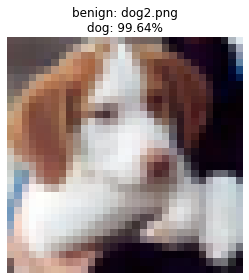

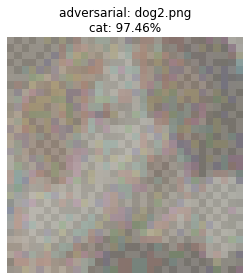

In [125]:
# original image
path = f'dog/dog2.png'
im = Image.open(f'./data/{path}')
logit = model(transform(im).unsqueeze(0).to(device))[0]
predict = logit.argmax(-1).item()
prob = logit.softmax(-1)[predict].item()
plt.title(f'benign: dog2.png\n{classes[predict]}: {prob:.2%}')
plt.axis('off')
plt.imshow(np.array(im))
plt.tight_layout()
plt.show()

# adversarial image 
adv_im = Image.open(f'./fgsm/{path}')
logit = model(transform(adv_im).unsqueeze(0).to(device))[0]
predict = logit.argmax(-1).item()
prob = logit.softmax(-1)[predict].item()
plt.title(f'adversarial: dog2.png\n{classes[predict]}: {prob:.2%}')
plt.axis('off')
plt.imshow(np.array(adv_im))
plt.tight_layout()
plt.show()


## Passive Defense - JPEG compression
JPEG compression by imgaug package, compression rate set to 70

Reference: https://imgaug.readthedocs.io/en/latest/source/api_augmenters_arithmetic.html#imgaug.augmenters.arithmetic.JpegCompression

In [ ]:
model = ptcv_get_model('resnet110_cifar10', pretrained=True).to(device)

In [110]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar_10_mean, cifar_10_std)
])

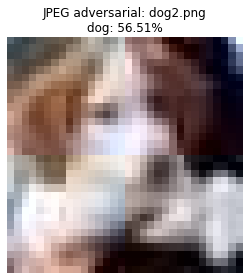

In [118]:
import imgaug.augmenters as iaa

# pre-process image
x = transforms.ToTensor()(adv_im)*255
x = x.permute(1, 2, 0).numpy()
x = x.astype(np.uint8)

# TODO: use "imgaug" package to perform JPEG compression (compression rate = 70)
aug = iaa.JpegCompression(compression=70)
compressed_x = aug(image=x)
# print(type(compressed_x))

logit = model(transform(compressed_x).unsqueeze(0).to(device))[0]
predict = logit.argmax(-1).item()
prob = logit.softmax(-1)[predict].item()
plt.title(f'JPEG adversarial: dog2.png\n{classes[predict]}: {prob:.2%}')
plt.axis('off')


plt.imshow(compressed_x)
plt.tight_layout()
plt.show()